In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

#### Step 1: Loading the Data

In [2]:
# Load data from Excel sheets
file_path = 'HrData.xlsx'
employee_df = pd.read_excel(file_path, sheet_name='Employee')
performance_df = pd.read_excel(file_path, sheet_name='PerformanceRating')

# Convert date columns to datetime
employee_df['HireDate'] = pd.to_datetime(employee_df['HireDate'])
performance_df['ReviewDate'] = pd.to_datetime(performance_df['ReviewDate'])

# Display sample data to verify loading
print("Employee Data Sample:")
print(employee_df.head())
print("\nPerformance Rating Data Sample:")
print(performance_df.head())

Employee Data Sample:
  EmployeeID   FirstName LastName      Gender  Age BusinessTravel  \
0  3012-1A41    Leonelle    Simco      Female   30    Some Travel   
1  CBCB-9C9D     Leonerd    Aland        Male   38    Some Travel   
2  95D7-1CE9       Ahmed    Sykes        Male   43    Some Travel   
3  47A0-559B  Ermentrude   Berrie  Non-Binary   39    Some Travel   
4  42CC-040A       Stace   Savege      Female   29    Some Travel   

        Department  DistanceFromHome State                Ethnicity  ...  \
0            Sales                27    IL                    White  ...   
1            Sales                23    CA                    White  ...   
2  Human Resources                29    CA  Asian or Asian American  ...   
3       Technology                12    IL                    White  ...   
4  Human Resources                29    CA                    White  ...   

   MaritalStatus  Salary StockOptionLevel OverTime   HireDate  Attrition  \
0       Divorced  102059      

---
#### Analysis 1: Employee Engagement Analysis
> Objective:
This analysis measures employee satisfaction and motivation using the EnvironmentSatisfaction column from performance data and correlates it with performance metrics (ManagerRating). It helps identify areas for improvement, such as the work environment or corporate culture, if satisfaction levels are low.

Average Environmental Satisfaction (1-5 scale): 3.71


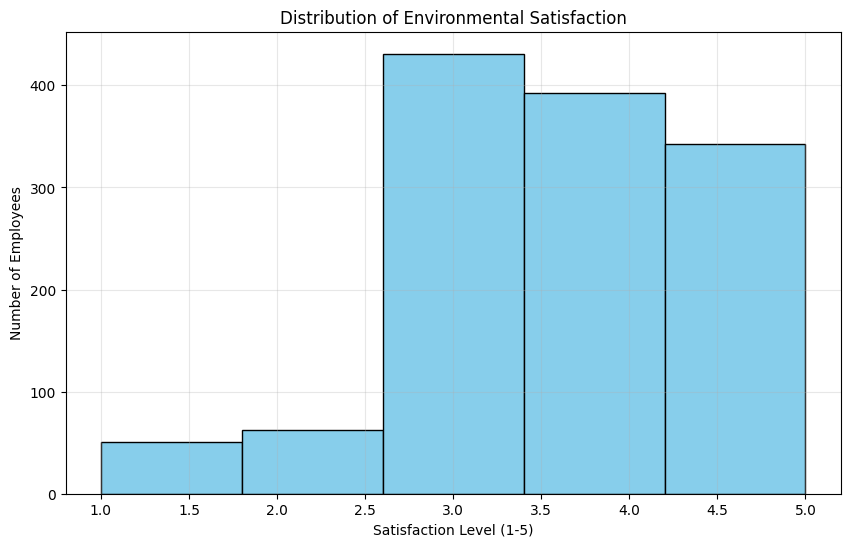

Correlation between Environmental Satisfaction and Manager Rating: 0.02


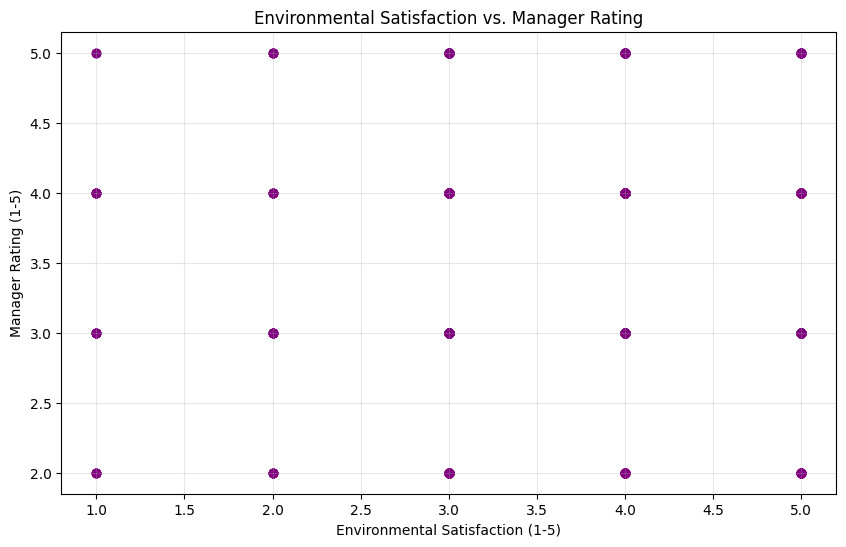

In [3]:
# Get the latest performance review per employee
latest_performance = performance_df.loc[performance_df.groupby('EmployeeID')['ReviewDate'].idxmax()]

# Merge with employee data
merged_df = pd.merge(employee_df, latest_performance, on='EmployeeID', how='left')

# Calculate average environmental satisfaction
env_satisfaction_avg = merged_df['EnvironmentSatisfaction'].mean()
print(f"Average Environmental Satisfaction (1-5 scale): {env_satisfaction_avg:.2f}")

# Visualize the distribution of Environmental Satisfaction
plt.figure(figsize=(10, 6))
plt.hist(merged_df['EnvironmentSatisfaction'].dropna(), bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Environmental Satisfaction')
plt.xlabel('Satisfaction Level (1-5)')
plt.ylabel('Number of Employees')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation with ManagerRating
correlation = merged_df['EnvironmentSatisfaction'].corr(merged_df['ManagerRating'])
print(f"Correlation between Environmental Satisfaction and Manager Rating: {correlation:.2f}")

# Scatter plot of Environmental Satisfaction vs. ManagerRating
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['EnvironmentSatisfaction'], merged_df['ManagerRating'], alpha=0.5, color='purple')
plt.title('Environmental Satisfaction vs. Manager Rating')
plt.xlabel('Environmental Satisfaction (1-5)')
plt.ylabel('Manager Rating (1-5)')
plt.grid(True, alpha=0.3)
plt.show()

##### Interpretation:
- Average Environmental Satisfaction: A score near 5 indicates high satisfaction, while a score below 3 suggests dissatisfaction and a need for improvement in the work environment or culture.
- Distribution: If the histogram skews left (higher values), most employees are satisfied. A right skew (lower values) indicates widespread dissatisfaction.
- Correlation: A positive value (e.g., 0.3 or higher) suggests that satisfied employees tend to receive better performance ratings, reinforcing the link between engagement and performance.

---
#### Analysis 2: Predictive Analytics
> Objective:
This analysis uses machine learning to predict human resource trends:
1. Which employees are most likely to leave? (Attrition prediction)
2. What factors influence high performance? (Performance prediction)
3. How can recruitment strategies be improved? (Inferred from insights)

#### 1. Attrition Prediction

Attrition Prediction Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       314
           1       0.85      0.50      0.63        70

    accuracy                           0.89       384
   macro avg       0.88      0.74      0.78       384
weighted avg       0.89      0.89      0.88       384

Feature Importances for Attrition Prediction:
                    Feature  Importance
5           YearsAtCompany    0.239835
6  YearsSinceLastPromotion    0.215694
0                      Age    0.169258
1         DistanceFromHome    0.127701
3          JobSatisfaction    0.069722
4          WorkLifeBalance    0.063582
7            ManagerRating    0.060758
2  EnvironmentSatisfaction    0.053449


/tmp/ipykernel_160157/684693721.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Reds_d')


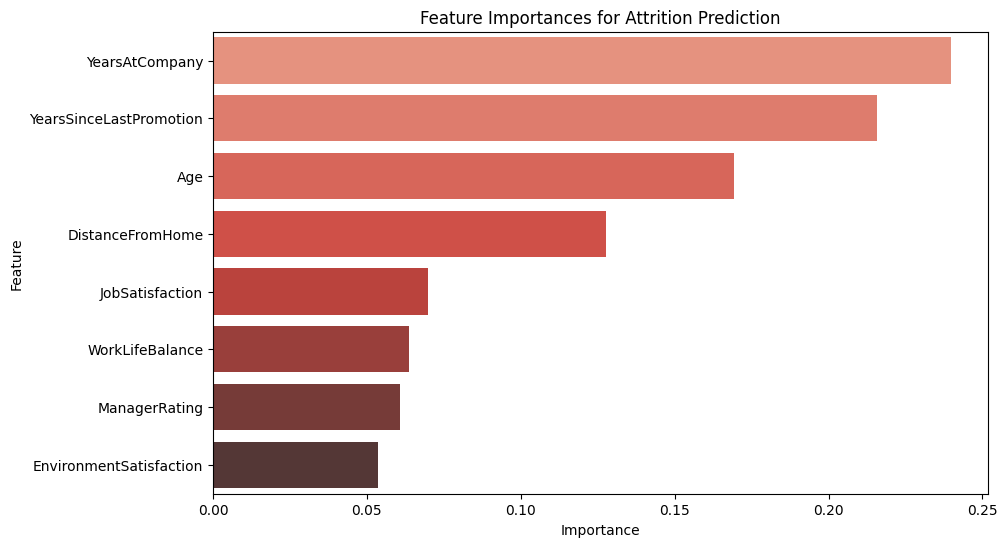

In [4]:
# Prepare data for attrition prediction
attrition_df = merged_df.copy()
attrition_df['Attrition'] = attrition_df['Attrition'].map({'Yes': 1, 'No': 0})

# Select features for prediction
features = ['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobSatisfaction', 
            'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'ManagerRating']

# Remove rows with missing values
attrition_df = attrition_df.dropna(subset=features + ['Attrition'])

# Split data into training and testing sets
X = attrition_df[features]
y = attrition_df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Attrition Prediction Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances for Attrition Prediction:\n", feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Reds_d')
plt.title('Feature Importances for Attrition Prediction')
plt.show()

#### 2. Performance Prediction

Performance Prediction Mean Squared Error: 0.00
Feature Importances for Performance Prediction:
                    Feature  Importance
5            ManagerRating         1.0
0                      Age         0.0
1  EnvironmentSatisfaction         0.0
2          JobSatisfaction         0.0
3          WorkLifeBalance         0.0
4           YearsAtCompany         0.0


/tmp/ipykernel_160157/3741518954.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Purples_d')


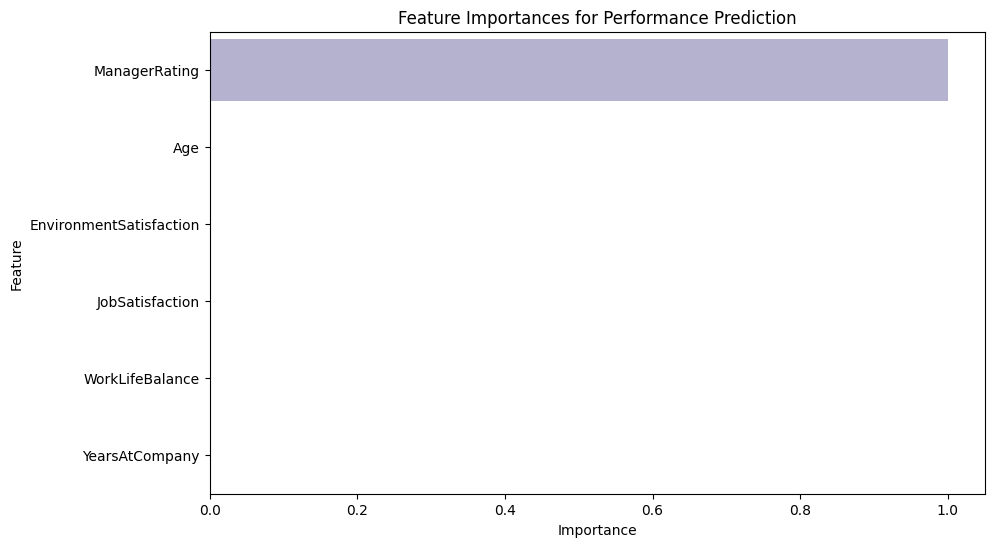

In [5]:
# Prepare data for performance prediction
performance_df = merged_df.copy()

# Select features for prediction
features = ['Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 
            'YearsAtCompany', 'ManagerRating']

# Remove rows with missing values
performance_df = performance_df.dropna(subset=features)

# Split data into training and testing sets
X = performance_df[features]
y = performance_df['ManagerRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Performance Prediction Mean Squared Error: {mse:.2f}")

# Feature importance
importances = reg.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances for Performance Prediction:\n", feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Purples_d')
plt.title('Feature Importances for Performance Prediction')
plt.show()